<font size="6">**Continuous Control: Reacher Environment**</font>

# Introduction

This report aims to summarize several experiments to solve the unity environment called *Reacher*, whose description is provided in `README.md` file.

There are two approaches discussed:
* single environment: `Continuous_Control-DDPG-v02.ipynb` (locally trained)
    * `models/ddpg2/` 
        * actor.pth
        * critic.pth
* 20 paralell environments: `Continuous_Control-DDPG-20a-v02.ipynb` (this environment is trained on Udacity Workspace)
    * `models/ddpg2-20a/` 
        * actor.pth
        * critic.pth
       

Boths approaches are solved using a DDPG Agent, discussed below. In addition the score by episode is shown for each agent and then sime final thoughts are shared

Results are stored in `models/experiments/`
Source code for agent and model is on ../src/ (on repository root folder)


In [7]:
import pandas as pd
import matplotlib.pyplot as plt

import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path

In [61]:
from os import path
import sys

repo_path = path.dirname(path.dirname(path.abspath("__file__")))
repo_path
sys.path.append(repo_path)

In [62]:
from src.ac_agent import AgentDDPG, OUNoise, GaussianProcess
from src.utils import get_noise_schedulling

In [8]:

plt.style.use(['seaborn-poster'])

In [35]:
def read_exp_scores():
    path = Path('models', 'experiments', '')
    all_files = path.glob(f"*.csv")
    all_files_lst = []
    for file in all_files:
        print(file)
        df = pd.read_csv(file, index_col='idx_episode')
        all_files_lst.append(df)
        
    return pd.concat(all_files_lst, axis=0)

In [36]:

scores_df = read_exp_scores()

models\experiments\scores_20210306200939.csv
models\experiments\scores_20210307105614.csv
models\experiments\scores_20210307113155.csv


# Learning Algorithm

The agent chosen to solve this environmnet is called `Deep Deterministic Policy Gradients`. It is an intereting algorithm that belongs to a familiy of algorithms called **Actor-Critic** agents.

A brief overview of agents is the following:
* Value Based Methods: Like **DQN**, they are aimed at estimating a function that is leveraged to choose among actions 
* Policy Based Methods: They try to directly estimate the best policy by computing policy gradients, a good example of this algorithms are **REINFORCE** and **PPO**
* Actor-Critic Methods: They are a combination of the former ones, an actor is used to estimate a policy $\mu$ and a critic is used to estimate a q-value function Q. There are several examples, like **A2C, A3C** and **DDPG**

Deep Deterministic Policy Gradient (DDPG) agents are also a generalizacion of DQNs to continuous action spaces, in fact, they both leverage the idea of a Buffer Replay and local and target networks

The Actor networks aims to estimate a policy, there are two versions:
$$\text{local: }\mu(s; \theta_{\mu}) $$ 
$$\text{target: }\mu'(s; \theta_{\mu'}) $$ 

While Critic networks provide an estimation for q-value function:
$$\text{local: }Q(s, \hat{a}; \theta_{Q}) $$ 
$$\text{target: }Q'(s; \hat{a}; \theta_{Q'}) $$ 



The actor loss is the policy gradient, defined as follows:
$$L_{i} = - \frac{1}{N}  \sum_{i} Q'(s, \mu(s;\theta_{\mu}); \theta_{Q'}) $$
Finally, the critic loss follows a definition very close to DQNs:
$$y_{i} = r_{i} + \gamma Q'(s,\mu'(s'; \theta_{\mu'}); \theta_{Q'})$$
$$L_{i} = \frac{1}{N}  \sum_{i} (Q(s,\mu(s; \theta_{\mu}); \theta_{Q})- y_{i})^{2}$$

Targe weights are updated periodically: θ_target = τ*θ_local + (1 - τ)*θ_target 

Moreover, in order to add stability to training several features are added:
* Gradient clipping in critic
* Update only every `learn_every` time steps
* Update a fixed `learn_num`  number of times

In addition, to provide some exploration capability, some decaying noise is added to actor's decisions (when interaction with the environment, not when learning). In the original paper *Ornstein-Uhlenbeck* (ou) noise is added. 

$$a_{t} = a_{t} + N_{t}*\epsilon^{t}$$ 

where $\epsilon$ is the decaying factor

## Network Architecture

Separate networks for actor and critic are set in the agent (in local and target versions). Boths share the following architecture:
`fc1 > bn1 > fc2 > out`, where fc stands for *fully-connected* and bn for *batch normalization (1d)*. *ReLU* activation functions are used in hidden units.

In critic network, $\hat{a}=\mu$ is added directly to the second layer, so in future both networks could be coalesced.

The actor, must supply a deterministc policy, that it is, an action vector (float). Therefore, a *tanh* activation function is set at the output layer. Consider that, depending on the problem, this output may have to be rescaled

On the other hand, the critic is an estimation of the q-value function, which is a regression problem, therefore, a *Linear* activation function is set.


## Hyper Parameters

### Problem
MAX_STEPS = 1000
GAMMA = 0.99  # Discount factor

### Noise (Gaussian)
NOISE_MU = 0
NOISE_SIGMA = 0.1
NOISE_MIN_WEIGHT = 0.15

### Agent 
ACT_HID_LAYERS = (256, 128)  # (fc1, fc2)  
CRIT_HID_LAYERS = (256, 128)  # (fc1, fc2)  
ACT_ADD_BN = (True)
CRIT_ADD_BN =(True)
GRAD_CLIP = (False, 1.)  # (actor, critic)  
BATCH_SIZE = 128
LEARNING_RATES = (1e-3, 1e-3)  # (actor, critic) 
WEIGHT_DECAY = (0, 0)  # (actor, critic) 
SOFT_UPD_PARAM = 1e-3
UPDATE_EVERY = 1
BUFFER_SIZE = int(1e6)
LEARN_EVERY = 20
LEARN_NUM = 10

It can be seen that Gausian noise is used intead of OU, this fact will be discussed afterwards. In addition, learning will happend every 20 time steps and every time it is triggered, 10 learning batches are executed. This tweak was found crucial on this environment (for example, on pendulum it is not necesary), the same can be said for gradient clipping

## Exploration vs Explotation

As previously introduced, Gaussian noise is used, because it is observed that the environment action spaces is on [-1, +1] range and OU noise is not centered at 0. There are other approaches like adding noise to parameters, but in order to keep implementation simple, noise was switched to Gausian

In [66]:
action_size = 1 
random_seed = 123

In [75]:
ou_noise1 = OUNoise(action_size, random_seed, mu=0., theta=0.15, sigma=0.2)
g_noise1 = GaussianProcess(action_size, random_seed, mu=0., sigma=0.1)

In [76]:
ou_noise1_df0 = get_noise_schedulling(1000, decay=1., noise=ou_noise1)
g_noise1_df0 = get_noise_schedulling(1000, decay=1., noise=g_noise1)


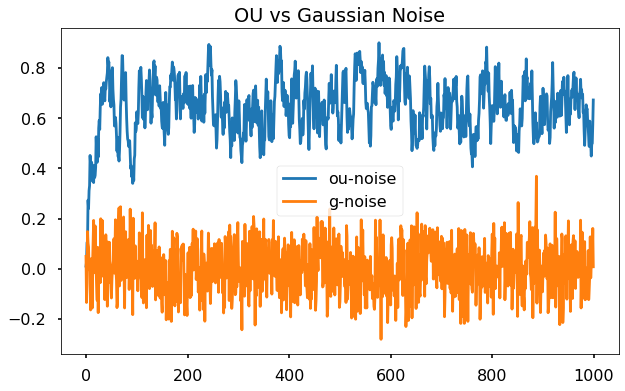

In [81]:
g = ou_noise1_df0.plot(y='noise_raw', label='ou-noise', figsize=(10, 6))
g_noise1_df0.plot(y='noise_raw', label='g-noise', ax=g)
plt.title('OU vs Gaussian Noise')

plt.show()

The following plot shows a decaying scheme for Gaussian in single environment, where chosen decay factor was .99975

In [96]:
g_noise1_df1 = get_noise_schedulling(3000, decay=.999, noise=g_noise1)
g_noise1_df2 = get_noise_schedulling(3000, decay=.99975, noise=g_noise1)
g_noise1_df3 = get_noise_schedulling(3000, decay=.9995, noise=g_noise1)

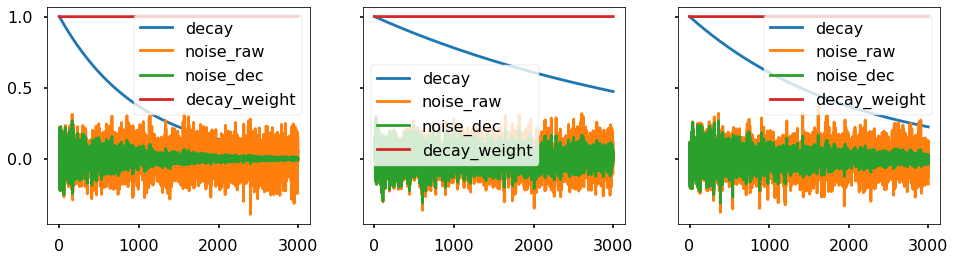

In [97]:
fig, axs = plt.subplots(1, 3, figsize=(16,4), sharey=True)

g_noise1_df1.plot(ax=axs[0])
g_noise1_df2.plot(ax=axs[1])
g_noise1_df3.plot(ax=axs[2])

plt.show()

The following plot shows a decaying scheme for Gaussian at 20 environments, where chosen decay factor was .992

In [87]:
g_noise1_df1 = get_noise_schedulling(1000, decay=.99, noise=g_noise1)
g_noise1_df2 = get_noise_schedulling(1000, decay=.992, noise=g_noise1)
g_noise1_df3 = get_noise_schedulling(1000, decay=.995, noise=g_noise1)

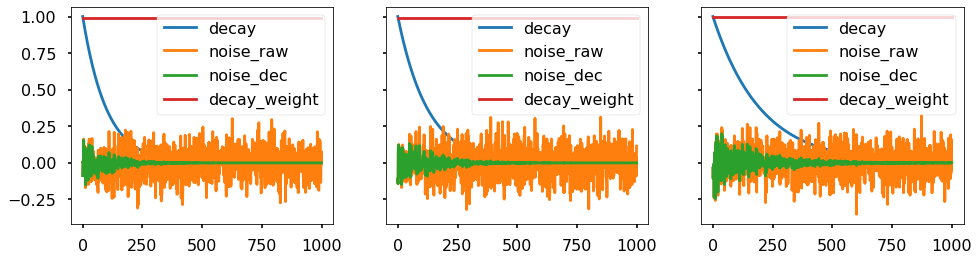

In [90]:
fig, axs = plt.subplots(1, 3, figsize=(16,4), sharey=True)

g_noise1_df1.plot(ax=axs[0])
g_noise1_df2.plot(ax=axs[1])
g_noise1_df3.plot(ax=axs[2])

plt.show()

# Agent Benchmark

This section shows agents score over time, for 20 agents set up, an average of 20 agents score at each episode is recorded.

Single environment, takes almost 2000 episodes to solve the environment whereas 20 envs takes only 200 (this experiment was run on GPU and each episode took longer)

In [40]:
select_scores_summary = ['avg_score', 'avg_score_mave100', 'experiment']

In [51]:
ddpg_v02_1a = scores_df.loc[scores_df['experiment'] == 'ddpg:v02', ['0'] + select_scores_summary]
ddpg_v02_20a = scores_df.loc[scores_df['experiment'] == 'ddpg-20a:v02', [str(int(i)) for i in range(0,20)] + select_scores_summary]
scores_df = scores_df[['avg_score', 'avg_score_mave100', 'experiment']]

In [18]:
experiments= ['ddpg:v02', 'ddpg-20a:v02']

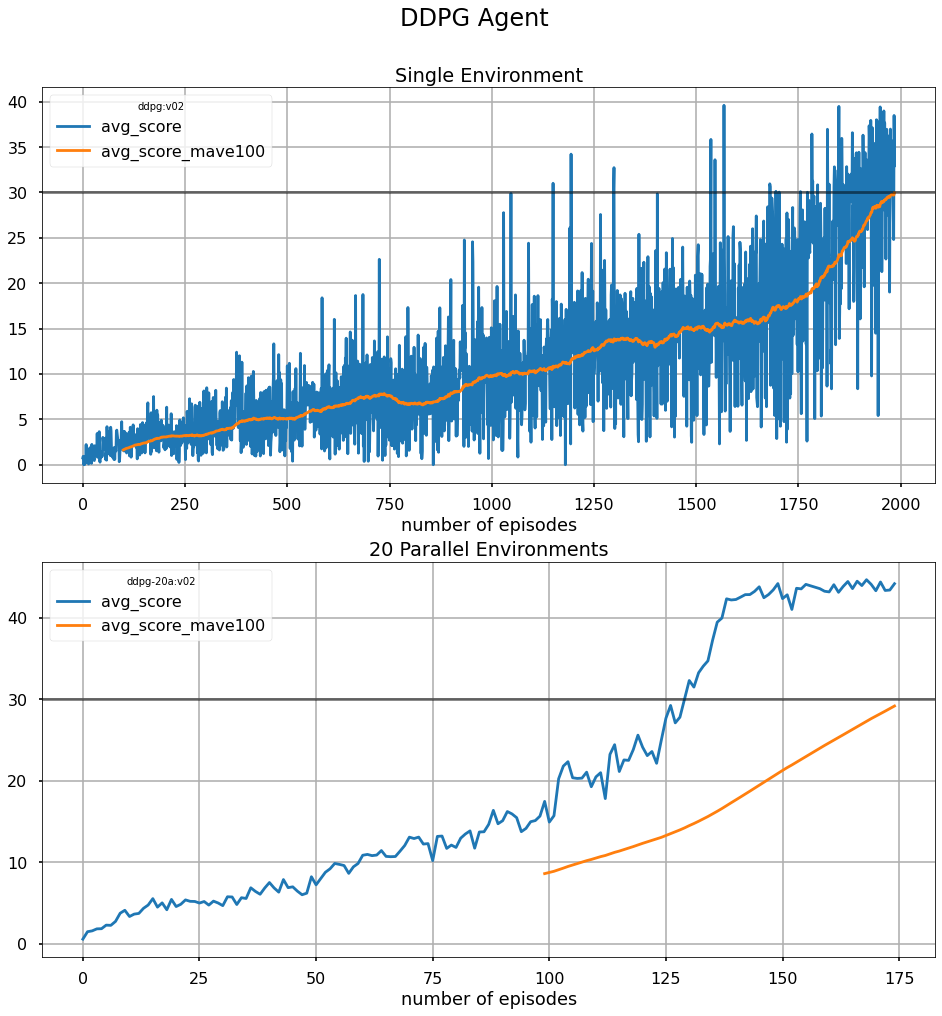

In [95]:
fig, axs = plt.subplots(len(experiments),1, figsize=(16,16))

for row_idx, ax in enumerate(axs):
    ax1 = axs[row_idx]
    experiment_name = experiments[row_idx]
    scores_df[scores_df['experiment']==experiment_name].plot(ax=ax)
    ax.axhline(30, color='black', alpha=0.5)  # solved at
    ax.legend(title=experiment_name)
    ax.set_xlabel('number of episodes')
    ax.grid()

axs[0].set_title('Single Environment')   
axs[1].set_title('20 Parallel Environments') 
plt.suptitle("DDPG Agent", fontsize=24, y=0.95)
plt.show()

# Discussion

Both approximations yield similar results, by accelerating their score gains at a certain point. The main challenges were:
* Gaussian noise seemed more convenient, as it does not add a skew to positive noises, however it also losses some statistical properties, this change also worked on other environments so it seemed a good idea 
* Setting noise paramenters appropiatelly, as if they are too low or to high, the agent did not improved, and it could not be identified whether there was a bug or a wrong hyperparamenter
* Understanding the importance of not learning at every step, as in other environments the agent worked well, but in this one it seem a feature of the utmost importance


## Further Steps:
* Coalescing Actor and Critic networks: As to reduce training time, the first layer could be shared. In addition, it will make notoriously faster the algorithm to learn from pixels
* Looking at the final number of episodes to solved the environment, faster decaying schedulles could work trigger convergence faster
* Smaller networks may allow for faster schemes (more frequent learning) so more hyperparamenter tunning to prune the network size could pay off with a more efficent agent
* In DQNs, it was found that updating target weights not every step but periodically, helped to stabilize the algorithm. Howerver, this approximation was tested on pendulum and it did not improved agents stability, futher research may be need to test whether this tweak may work on this environment